# AE2

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

### format danych

In [6]:
r800 = pd.read_csv("cutting/r800.csv", header=None)

In [ ]:
# szerokość, wysokość, wartość

In [16]:
r800

,width,height,value
0,250,120,100
1,320,160,500
2,250,160,600
3,150,120,40
4,400,30,400


### deterministic algorithm :)

In [494]:
# find all desks in this vertical path
# calculate vertical space between each found rectangle
# if there is vertical space > height, put the desk over there
# if there is no such space, then put it under lowest collision
# if there are no collisions, put it in the highest available space in vertical path

In [8]:
""" Config """
DEBUG = False

In [9]:
def sort_by_real_value(data: pd.DataFrame):
    """ sorts by value per one unit of measure, modifies data inplace """
    data.columns = ['width', 'height', 'value']
    data['real_value'] = data['value'] / (data['width'] * data['height'])
    data.sort_values(by='real_value', ascending=False, inplace=True)
    data.drop(['real_value'], axis=1, inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [166]:
class Stock:

    def __init__(self, radius):
        self.radius = radius
        self.rectangles = np.empty((0, 5)) # bottom left corner x, y, width, height, value

    def is_within_circle(self, x, y, width, height):
        corners = [(x, y), (x + width, y), (x, y + height), (x + width, y + height)]
        for corner in corners:
            if np.sqrt(corner[0]**2 + corner[1]**2) > self.radius:
                return False
        return True

    def is_not_overlapping(self, x, y, width, height):
        for rect in self.rectangles:
            if (x + width > rect[0] and x < rect[0] + rect[2]) and (y + height > rect[1] and y < rect[1] + rect[3]):
                return False
        return True
    
    def visualize(self):
        fig, ax = plt.subplots()
    
        circle = plt.Circle((0, 0), self.radius, color='blue', fill=False, linewidth=2)
        ax.add_patch(circle)
    
        for rect in self.rectangles:
            x, y, width, height, _ = rect
            rectangle = plt.Rectangle((x, y), width, height, edgecolor='black', facecolor='yellow', linewidth=1)
            ax.add_patch(rectangle)
    
        ax.set_aspect('equal', 'box')
        offset = int(self.radius / 16)
        ax.set_xlim(-self.radius - offset, self.radius + offset)
        ax.set_ylim(-self.radius - offset, self.radius + offset)
        ax.set_title(f'R = {self.radius}')
    
        plt.show()

    def fitness(self):
        return np.sum(self.rectangles, axis=0)[4]

    def get_vertical_collisions(self, x_left, x_right):
        vertical_collisions = []
        bottom_point = self.find_highest_point(x_left, x_right)
        
        for rect in self.rectangles:
            rect_left = rect[0]
            rect_right = rect[0] + rect[2]
            if (x_right > rect_left and x_left < rect_right) and (rect[1] < int(bottom_point[1])):
                vertical_collisions.append(rect)
                
        bottom_point = self.find_highest_point(x_left, x_right)
        vertical_collisions.append(np.array([int(bottom_point[0]), int(bottom_point[1]), x_right-x_left, self.radius - int(bottom_point[1]), 0]))
        return vertical_collisions
    
    def calculate_vertical_spaces(self, vertical_collisions):
        
        vertical_collisions = sorted(vertical_collisions, key=lambda r: r[1])
        vertical_spaces = [(-self.radius, vertical_collisions[0][1])]

        for i in range(1, len(vertical_collisions)):
            bottom = vertical_collisions[i-1][1] + vertical_collisions[i-1][3]
            top = vertical_collisions[i][1]
            vertical_spaces.append((bottom, top))

        return vertical_spaces
    
    def find_highest_point(self, x1, x2):
        num_points = int((x2 - x1) * 2)
        points = []
        for i in range(num_points):
            angle = 2 * math.pi * i / num_points
            x = (self.radius - 1) * math.cos(angle)
            y = (self.radius - 1) * math.sin(angle)
            if x > x1 and x < x2 and y >= 0:
                points.append([x, y])
        points = np.array(points)
        return points[np.argmin(points[:, 1])]

class EA:

    def __init__(self, data, radius, population_size=10, generations=5):
        self.data = sort_by_real_value(data.copy()) # desk['width'], desk['height'], desk['value']
        self.radius = radius
        self.population_size = population_size
        self.generations = generations
        self.population = []
    
    def evaluation(self, population):
        return [stock.fitness() for stock in population]

    def initialize(self, n_retries=20):

        for individual in range(self.population_size):
            stock = Stock(self.radius)
            for i, desk in self.data.iterrows():
                # print(f"DESK {i}")
                tries = 0
                while tries < n_retries:
                    x = random.uniform(-self.radius, self.radius - desk['width'])
                    y = random.uniform(-self.radius, self.radius - desk['height'])
                    if stock.is_within_circle(x, y, desk['width'], desk['height']) and stock.is_not_overlapping(x, y, desk['width'], desk['height']):
                        stock.rectangles = np.vstack((stock.rectangles, [x, y, desk['width'], desk['height'], desk['value']]))
                    else:
                        tries += 1
            self.population.append(stock)

    def mutation(self, individual: Stock, mutation_rate=1, n_retries=100):
        if np.random.rand() < mutation_rate:
            # modify
            for i in range(len(individual.rectangles)):
                rect = individual.rectangles[0]
                individual.rectangles =  individual.rectangles[1:]
                desk = {'width': rect[2], 'height': rect[3], 'value': rect[4]}
                x, y = rect[0], rect[1]
                try:
                    vertical_collisions = individual.get_vertical_collisions(x, x + desk['width'])
                except Exception:
                    individual.rectangles = np.vstack((individual.rectangles, rect))
                    continue
                vertical_spaces = individual.calculate_vertical_spaces(vertical_collisions)
    
                if DEBUG:
                    print('Collisions:', vertical_collisions)
                    print('Spaces:', vertical_spaces)

                placed = False
                for (bottom, top) in reversed(vertical_spaces):
                    diff = top - bottom
                    if DEBUG:
                        print('DIFF:', diff)
                    if diff >= desk['height']:
                        y = top - desk['height']
                        if individual.is_within_circle(x, y, desk['width'], desk['height']):
                            individual.rectangles = np.vstack((individual.rectangles, [x, y, desk['width'], desk['height'], desk['value']]))
                            k += 1
                            placed = True
                            if DEBUG:
                                print(f"Rectangle {k} placed:", x, y, desk['width'], desk['height'])
                            break
                if not placed:
                    individual.rectangles = np.vstack((individual.rectangles, rect))
            # add new           
            for i, desk in self.data.iterrows():
                # print(f"DESK {i}")
                tries = 0
                while tries < n_retries:
                    x = random.uniform(-self.radius, self.radius - desk['width'])
                    y = random.uniform(-self.radius, self.radius - desk['height'])
                    if individual.is_within_circle(x, y, desk['width'], desk['height']) and individual.is_not_overlapping(x, y, desk['width'], desk['height']):
                        individual.rectangles = np.vstack((individual.rectangles, [x, y, desk['width'], desk['height'], desk['value']]))
                    else:
                        tries += 1
        return individual
    
    def train(self, n_retries=100):
        self.initialize(n_retries=n_retries)
        for generation in range(self.generations):
            
            new_population = []
            
            # no crossover

            for i, parent in enumerate(self.population):
                child = self.mutation(parent, n_retries)
                self.population[i] = child 

            fitness = self.evaluation(self.population)
            best_individual = self.population[np.argmax(fitness)]
            best_fitness = best_individual.fitness()
            # best_individual.visualize()
            print(f"Generation {generation+1}: best individual: {best_individual}, fitness: {best_fitness}")

        fitness = self.evaluation(self.population)
        best_individual = self.population[np.argmax(fitness)]
        best_individual.visualize()
        best_fitness = best_individual.fitness()
        return best_individual
    


## Dane

#### R = 800

Generation 1: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 23180.0
Generation 2: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 24820.0
Generation 3: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 26420.0
Generation 4: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 26820.0
Generation 5: best individual: <__main__.Stock object at 0x00000206F93F6E10>, fitness: 27320.0
Generation 6: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 27620.0
Generation 7: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 28020.0
Generation 8: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 28060.0
Generation 9: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 28060.0
Generation 10: best individual: <__main__.Stock object at 0x00000206F99F00D0>, fitness: 28060.0
Generation 11: best individual: <__main__.Stock o

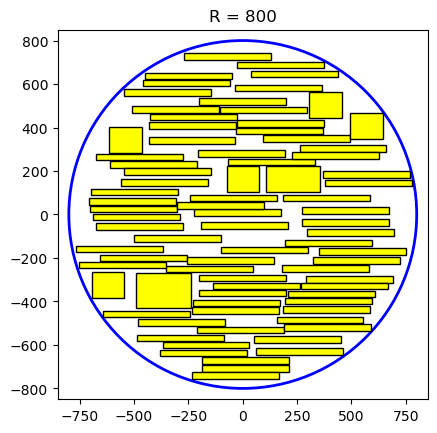

In [143]:
ea = EA(r800, 800, population_size=20, generations=30)
ea.train(n_retries=150)

#### 850

In [144]:
r850 = pd.read_csv("cutting/r850.csv", header=None)

Generation 1: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 299890.0
Generation 2: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 306430.0
Generation 3: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 308440.0
Generation 4: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 311350.0
Generation 5: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 312400.0
Generation 6: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 313540.0
Generation 7: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 313840.0
Generation 8: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 315010.0
Generation 9: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 315610.0
Generation 10: best individual: <__main__.Stock object at 0x00000206F97CE290>, fitness: 316630.0
Generation 11: best individual: <__main

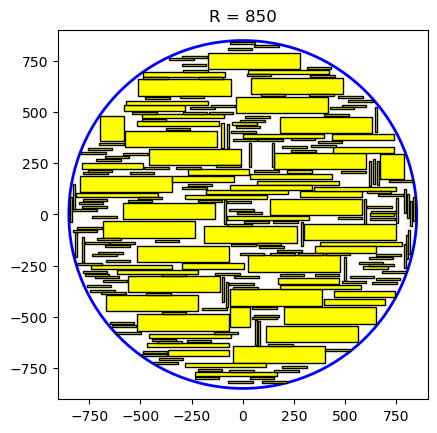

In [147]:
ea = EA(r850, 850, population_size=10, generations=20)
ea.train(n_retries=120)

#### 1000

In [151]:
r1000 = pd.read_csv("cutting/r1000.csv", header=None)

Generation 1: best individual: <__main__.Stock object at 0x00000206F94F3010>, fitness: 16800.0
Generation 2: best individual: <__main__.Stock object at 0x00000206F9477AD0>, fitness: 16980.0
Generation 3: best individual: <__main__.Stock object at 0x00000206F86731D0>, fitness: 17280.0
Generation 4: best individual: <__main__.Stock object at 0x00000206F86731D0>, fitness: 17520.0
Generation 5: best individual: <__main__.Stock object at 0x00000206F9477AD0>, fitness: 17700.0
Generation 6: best individual: <__main__.Stock object at 0x00000206F9477AD0>, fitness: 17700.0
Generation 7: best individual: <__main__.Stock object at 0x00000206F9477AD0>, fitness: 17740.0
Generation 8: best individual: <__main__.Stock object at 0x00000206F9477AD0>, fitness: 17740.0
Generation 9: best individual: <__main__.Stock object at 0x00000206F9477AD0>, fitness: 17780.0
Generation 10: best individual: <__main__.Stock object at 0x00000206F9477AD0>, fitness: 17820.0
Generation 11: best individual: <__main__.Stock o

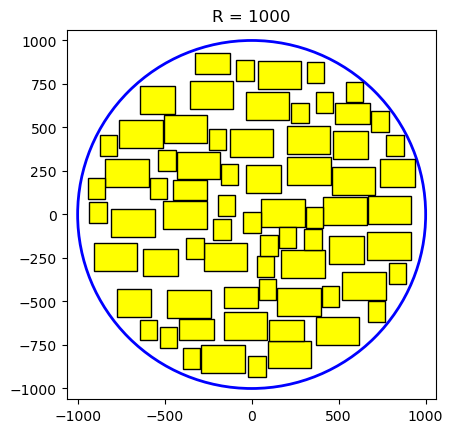

In [154]:
ea3 = EA(r1000, 1000, population_size=10, generations=20)
ea3.train(n_retries=120)

#### 1100

In [155]:
r1100 = pd.read_csv("cutting/r1100.csv", header=None)

Generation 1: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 24720.0
Generation 2: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 24920.0
Generation 3: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 24920.0
Generation 4: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 25040.0
Generation 5: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 25080.0
Generation 6: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 25080.0
Generation 7: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 25080.0
Generation 8: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 25080.0
Generation 9: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 25120.0
Generation 10: best individual: <__main__.Stock object at 0x00000206F84B7910>, fitness: 25160.0
Generation 11: best individual: <__main__.Stock o

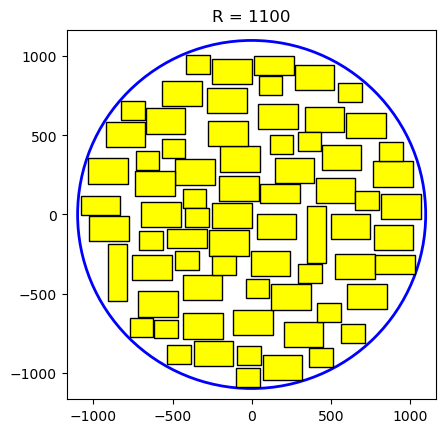

In [160]:
ea4 = EA(r1100, 1100, population_size=20, generations=50)
ea4.train(n_retries=200)

#### 1200

In [167]:
r1200 = pd.read_csv("cutting/r1200.csv", header=None)

Generation 1: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 26680.0
Generation 2: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 26800.0
Generation 3: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 26880.0
Generation 4: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 26960.0
Generation 5: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 26960.0
Generation 6: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 27000.0
Generation 7: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 27000.0
Generation 8: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 27040.0
Generation 9: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 27080.0
Generation 10: best individual: <__main__.Stock object at 0x00000206F9FB7A50>, fitness: 27080.0
Generation 11: best individual: <__main__.Stock o

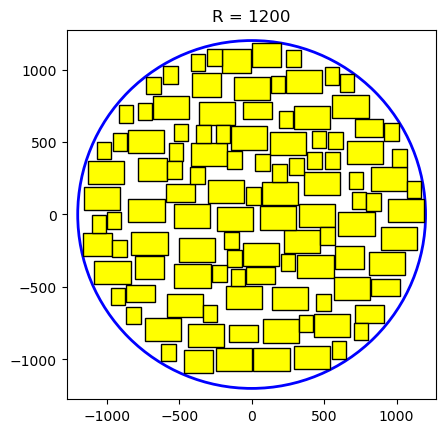

In [168]:
ea5 = EA(r1200, 1200, population_size=40, generations=100)
ea5.train(n_retries=200)